# Transfer Learning VGG16: wikiart classification dataset

### Autor: Silvia García Hernández
### Fecha: 22/06/2019

Using the wikiart classification dataset (https://paperswithcode.com/dataset/wikiart), I wrote a nootebook that uses a Transfer Learning model (VGG16) to make predictions in wikiart dataset. The number of classes used is 5: Cubism, Minimalism, Pop_Art, Rococo and Ukiyo_e. The model has some overfitting but the acc in the test set is high (>80%). It was a test to experiment with Transfer Learning.

## Librerías

In [39]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard
import numpy as np
from keras import applications
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
import keras
from time import time

## Directorios train, validation

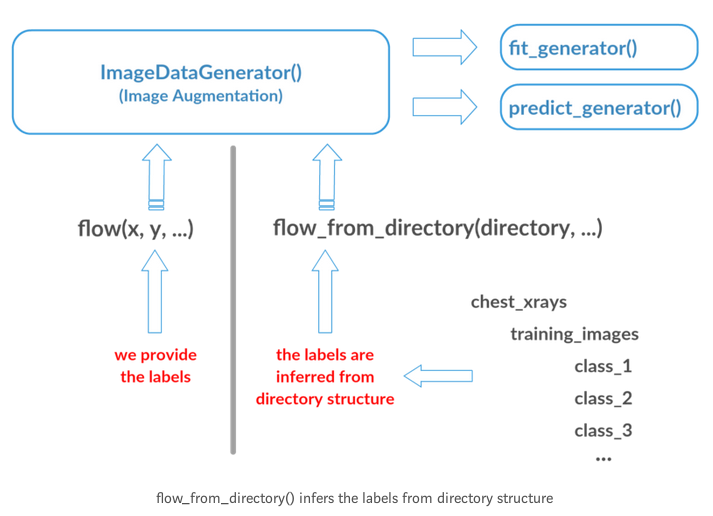

In [38]:
from IPython.display import Image
Image("/home/equipo/Pictures/direc.png")

In [40]:
BATCH_SIZE = 32

train_data_dir = 'datasets/train'
validation_data_dir = 'datasets/validation'

train_datagen = ImageDataGenerator(
        rescale=1./255)

validation_datagen = ImageDataGenerator(        
        rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALIDATION = validation_generator.n // validation_generator.batch_size

Found 5348 images belonging to 5 classes.
Found 1311 images belonging to 5 classes.


## Clases de la clasificación

In [2]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'Cubism', 1: 'Minimalism', 2: 'Pop_Art', 3: 'Rococo', 4: 'Ukiyo_e'}


## Ploteo de proporciones de datos

In [3]:
def percentage_value(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

In [4]:
def plot_dataset_description(path, title):
    classes = []
    for filename in iglob(os.path.join(path, "**", "*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])

    classes_cnt = Counter(classes)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()

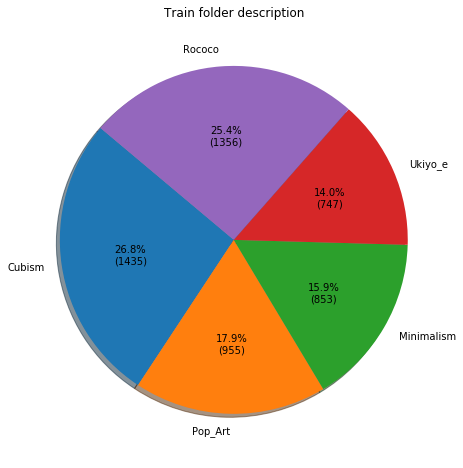

In [5]:
from glob import iglob
import os, os.path
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline 

plot_dataset_description(train_data_dir, "Train folder description")

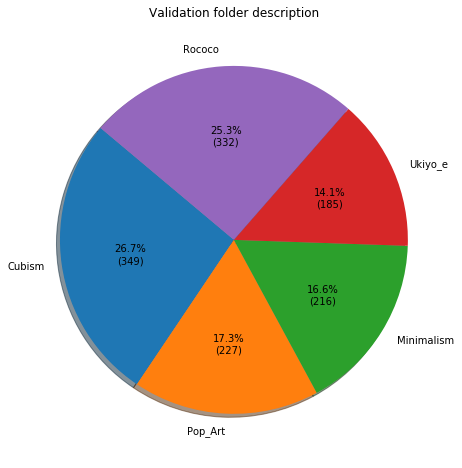

In [6]:
plot_dataset_description(validation_data_dir, "Validation folder description")

## VGG16

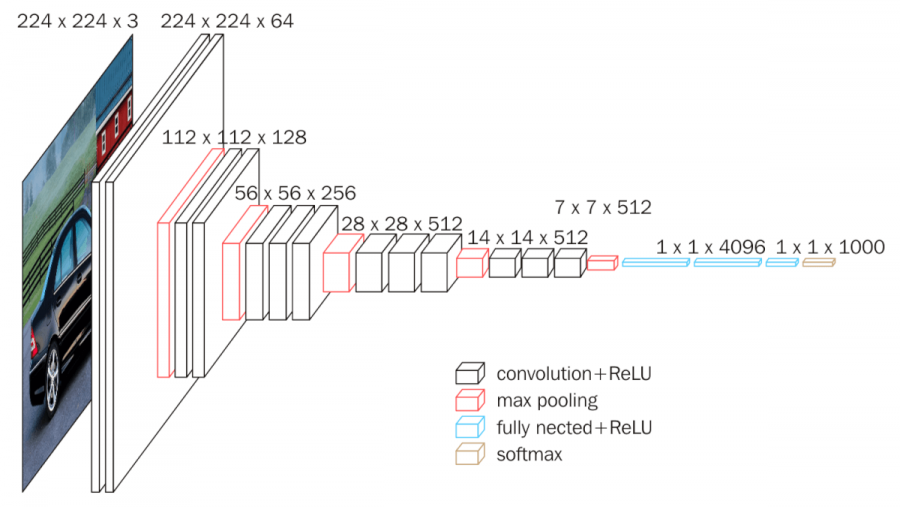

In [7]:
from IPython.display import Image
Image("/home/equipo/Pictures/vgg.png")

## Pretrained model

In [8]:
conv_model = applications.VGG16(include_top=False, weights='imagenet')

encoder = LabelBinarizer()

Instructions for updating:
Colocations handled automatically by placer.


## Train Bottleneck

In [9]:
bottleneck_features_train = conv_model.predict_generator(
    train_generator,
    steps=STEP_SIZE_TRAIN)

np.save(open('bottleneck_features_train.npy', 'wb'),
        bottleneck_features_train)

np.save(open('bottleneck_labels_train.npy', 'wb'),
        encoder.fit_transform(train_generator.classes))

## Validation Bottleneck

In [10]:
bottleneck_features_validation = conv_model.predict_generator(
    validation_generator,
    steps=STEP_SIZE_VALIDATION)

np.save(open('bottleneck_features_validation.npy', 'wb'),
        bottleneck_features_validation)

np.save(open('bottleneck_labels_validation.npy', 'wb'),
        encoder.fit_transform(validation_generator.classes))

## Dimensiones de los bottleneck

In [11]:
print("Train feature maps shape:", bottleneck_features_train.shape)
print("Validation feature maps shape:", bottleneck_features_validation.shape)

Train feature maps shape: (5344, 4, 4, 512)
Validation feature maps shape: (1280, 4, 4, 512)


## Sumario de la VGG16

In [12]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Carga de bottlenecks

In [13]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = np.load(open('bottleneck_labels_train.npy', 'rb'))

validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = np.load(open('bottleneck_labels_validation.npy', 'rb'))

## Model

In [18]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(5, activation='softmax'))

model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adadelta(),
              metrics = ['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Training

In [19]:
vgg16_model = model.fit(train_data, train_labels[:5344],
          epochs=15,
          batch_size=32,
          shuffle=True,
          validation_data=(validation_data, validation_labels[:1280]))

#model.save_weights(top_model_weights_path)

Instructions for updating:
Use tf.cast instead.
Train on 5344 samples, validate on 1280 samples
Epoch 1/15
5344/5344 [==============================] - 2s 413us/step - loss: 0.8694 - acc: 0.6871 - val_loss: 0.5140 - val_acc: 0.8281
Epoch 2/15
5344/5344 [==============================] - 2s 317us/step - loss: 0.5477 - acc: 0.7985 - val_loss: 0.5213 - val_acc: 0.8148
Epoch 3/15
5344/5344 [==============================] - 2s 317us/step - loss: 0.4581 - acc: 0.8308 - val_loss: 0.4976 - val_acc: 0.8273
Epoch 4/15
5344/5344 [==============================] - 2s 315us/step - loss: 0.3911 - acc: 0.8595 - val_loss: 0.5401 - val_acc: 0.8141
Epoch 5/15
5344/5344 [==============================] - 2s 316us/step - loss: 0.3291 - acc: 0.8761 - val_loss: 0.4985 - val_acc: 0.8242
Epoch 6/15
5344/5344 [==============================] - 2s 317us/step - loss: 0.2892 - acc: 0.8920 - val_loss: 0.5713 - val_acc: 0.8195
Epoch 7/15
5344/5344 [==============================] - 2s 317us/step - loss: 0.2524 - a

## Ploteo de acc y loss

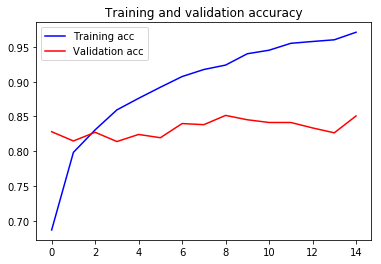

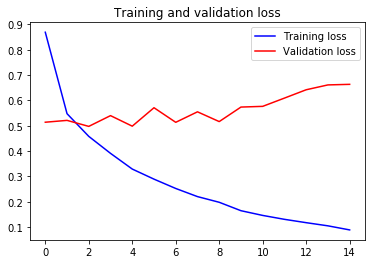

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = vgg16_model.history['acc']
val_acc = vgg16_model.history['val_acc']
loss = vgg16_model.history['loss']
val_loss = vgg16_model.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## Directorio test

In [21]:
test_data_dir = 'datasets/test'
test_datagen = ImageDataGenerator(rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (150, 150),
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = 'categorical')

Found 1622 images belonging to 5 classes.


## Ploteo de proporciones

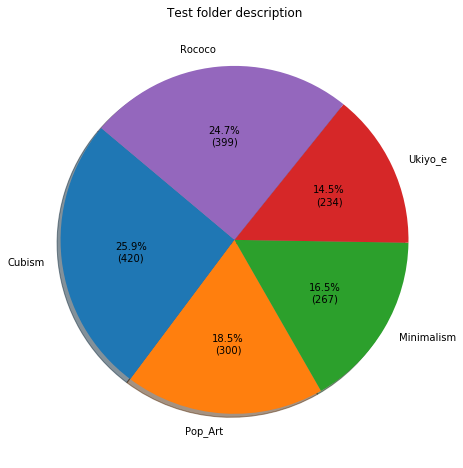

In [22]:
plot_dataset_description(test_data_dir, "Test folder description")

## Test Bottleneck

In [23]:
conv_model = applications.VGG16(include_top=False, weights='imagenet')
encoder = LabelBinarizer()

bottleneck_features_test = conv_model.predict_generator(
    test_generator,
    steps = test_generator.samples // test_generator.batch_size)

np.save(open('bottleneck_features_test.npy', 'wb'),
        bottleneck_features_test)

np.save(open('bottleneck_labels_test.npy', 'wb'),
        encoder.fit_transform(test_generator.classes))

## Carga de bottleneck

In [24]:
test_data = np.load(open('bottleneck_features_test.npy', 'rb'))

In [25]:
test_data.shape

(1600, 4, 4, 512)

## Predicciones

In [26]:
Y_pred = model.predict(test_data[:1600])

y_pred = np.argmax(Y_pred, axis = 1)

In [29]:
y_test = test_generator.classes

## Matriz de confusión

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cnf_matrix = confusion_matrix(y_test[:1600], y_pred)

In [32]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

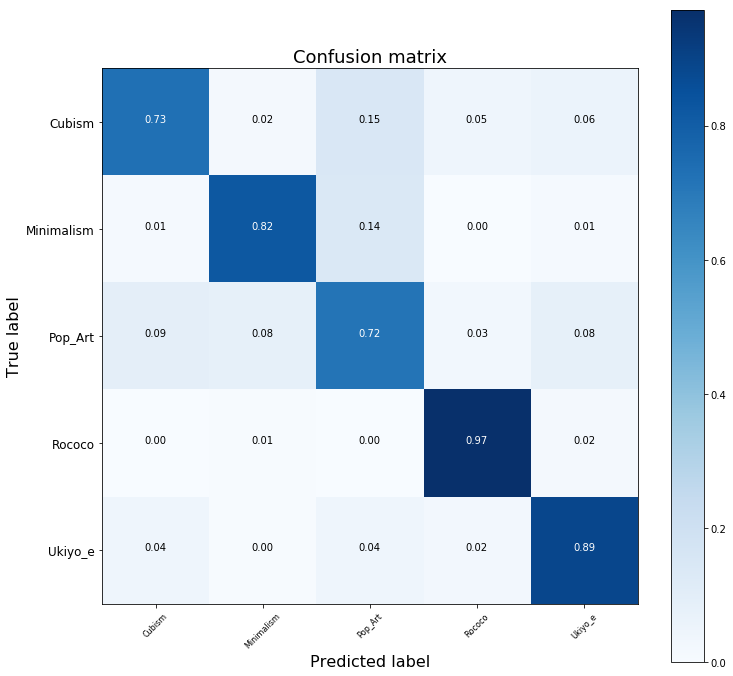

In [33]:
import itertools

plot_confusion_matrix(cnf_matrix, list(classes.values()))

In [35]:
print('Confusion Matrix')
print(confusion_matrix(y_test[:1600], y_pred))

Confusion Matrix
[[307   8  61  19  25]
 [  4 220  38   1   4]
 [ 28  25 215   8  24]
 [  0   2   1 389   8]
 [  9   1   9   5 189]]


## Classification report

In [37]:
print(classification_report(y_test[:1600], y_pred, target_names = list(classes.values())))

              precision    recall  f1-score   support

      Cubism       0.88      0.73      0.80       420
  Minimalism       0.86      0.82      0.84       267
     Pop_Art       0.66      0.72      0.69       300
      Rococo       0.92      0.97      0.95       400
     Ukiyo_e       0.76      0.89      0.82       213

   micro avg       0.82      0.82      0.82      1600
   macro avg       0.82      0.83      0.82      1600
weighted avg       0.83      0.82      0.82      1600

